# Graph-based text summarization on the material of Russian news

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import wordpunct_tokenize
import numpy as np
import networkx as nx
import gzip
from nltk.tokenize.punkt import PunktSentenceTokenizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import string

## Reformat data to csv

In [2]:
# import os
# import gzip
# import pandas as pd

# data = []
# directory = 'meduza/2019/'
# for filename in os.listdir(directory):
#     file = gzip.open(os.path.join(directory, filename), "rt")
#     filedata = file.readlines()
#     data.append(filedata[0])

# df = pd.DataFrame()
# df['text'] = data
# df.to_csv('meduza_news_2019.csv', index=False)

In [3]:
df = pd.read_csv('meduza_news_2019.csv')

In [4]:
df.head()

,text
0,Федеральные телеканалы показывали новости об у...
1,Полицейские отпустили участников одиночных пик...
2,"Таксист из Москвы заявил в полицию, что 20 ноя..."
3,"Samsung Galaxy S10, представленный 20 февраля ..."
4,На новейшего «Аладдина» от студии «Дисней» мож...


In [5]:
len(df)

10769

## Method 1 (basic)  
Input article → split into sentences → remove stop words → build a similarity matrix → generate rank based on matrix → pick top N sentences for summary.  
source: https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70

In [36]:
def read_article(text):
    article = text.split(". ")
    sentences = []

    for sentence in article:
        # print(sentence)
        sentences.append(sentence.replace("[^а-яА-Я]", " ").split(" "))
    sentences.pop() 
    
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


def generate_summary(file_name, top_n):
    stop_words = stopwords.words('russian')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    # nx.draw_networkx(sentence_similarity_graph)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    # print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    # print("Summarized Text: \n", ". ".join(summarize_text))
    
    return summarize_text

Видеоблогер BadComedian (Евгений Баженов) заявил, что против него подали судебный иск на один миллион рублей из-за обзора фильма «За гранью реальности»
Об этом Баженов рассказал в ролике на ютьюбе
«Здравствуйте
Меня зовут BadComedian и мне тут подумалось: а не закрыть ли мне канал? Почему? Потому что уже полгода меня судят», — сказал блогер
Иск в январе 2019 года подала кинокомпания KINODANZ (с 2019 года KD Studios), снявшая фильм «За гранью реальности»
По словам Баженова, его обвиняют в нарушении авторских прав из-за того, что в своем обзоре он использовал кадры из киноленты
BadComedian назвал поданный иск «попыткой цензурировать критику»
Блогер утверждает, что представители KINODANZ говорили ему, что за компанией «стоят очень влиятельные люди» и ее поддерживает Минкульт РФ
В поддержку BadComedian выступил продюсер Александр Роднянский
«Попытки заставить Евгения Баженова прекратить публиковать свои обзоры — это, если уж называть вещи своими именами, трусость, непрофессионализм и цензу

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


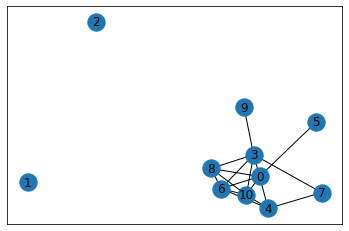

In [26]:
generate_summary(df['text'][33], 3)

#### Basic method already gives decent results.

## Method 2 (with sklearn tools)

source: https://joshbohde.com/blog/document-summarization/

In [38]:
def textrank(document):
    sentence_tokenizer = PunktSentenceTokenizer()
    sentences = sentence_tokenizer.tokenize(document)
 
    bow_matrix = CountVectorizer().fit_transform(sentences)
    normalized = TfidfTransformer().fit_transform(bow_matrix)
 
    similarity_graph = normalized * normalized.T
 
    nx_graph = nx.from_scipy_sparse_matrix(similarity_graph)
    # nx.draw_networkx(nx_graph)
    scores = nx.pagerank(nx_graph)
    return sorted(((scores[i],s) for i,s in enumerate(sentences)),
                  reverse=True)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Видеоблогер BadComedian (Евгений Баженов) заявил, что против него подали судебный иск на один миллион рублей из-за обзора фильма «За гранью реальности».
BadComedian выпустил обзор на фильм «За гранью реальности» в мае 2018 года.
Иск в январе 2019 года подала кинокомпания KINODANZ (с 2019 года KD Studios), снявшая фильм «За гранью реальности».


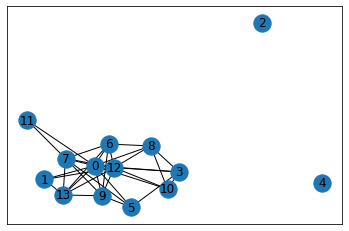

In [9]:
for text in textrank(df['text'][33])[:3]:
    print(text[1])

#### Because of another weighting results are different sometimes.

## Method 3 (with pretrained embeddings)

source: https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/

In [10]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
# !gzip -d cc.ru.300.vec.gz

In [11]:
word_embeddings = {}
f = open('cc.ru.300.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [12]:
len(word_embeddings)

2000000

In [13]:
def preprocess(text):
    stop_words = stopwords.words('russian')
    sentence_tokenizer = PunktSentenceTokenizer()
    sentences = sentence_tokenizer.tokenize(text)
    tokens = [wordpunct_tokenize(sentence) for sentence in sentences]
    clean_sentences = [[token.lower() for token in tokenized if token not in string.punctuation+'«»—».»,'
                       and token not in stop_words] 
                       for tokenized in tokens]

    return sentences, [' '.join(sentence) for sentence in clean_sentences]

In [14]:
sentences, processed_sentences = preprocess(df['text'][33])

In [15]:
sentence_vectors = []
for i in processed_sentences:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split()))
    else:
        v = np.zeros((300,))
    
    sentence_vectors.append(v)

In [16]:
sim_mat = np.zeros([len(sentences), len(sentences)])

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,300), sentence_vectors[j].reshape(1,300))[0,0]

In [19]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


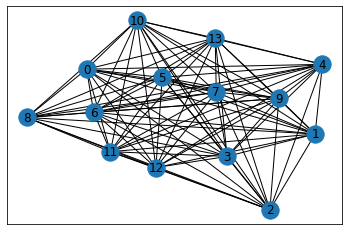

In [20]:
nx.draw_networkx(nx_graph)

In [21]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [22]:
for i in range(3):
    print(ranked_sentences[i][1])

Видеоблогер BadComedian (Евгений Баженов) заявил, что против него подали судебный иск на один миллион рублей из-за обзора фильма «За гранью реальности».
В своем ролике автор, в частности, критиковал министерство культуры и Фонд кино за выделение средств на съемки этой картины.
«Попытки заставить Евгения Баженова прекратить публиковать свои обзоры — это, если уж называть вещи своими именами, трусость, непрофессионализм и цензура», — заявил он.


#### The graph looks much more dense probably because of preprocessing and the results are quite strange and less logical than in previous methods.

## Method 4 - SummaNLP

In [23]:
from summa.summarizer import summarize

In [27]:
summarize(df['text'][33], language='russian', ratio=0.3).split('\n')

['Видеоблогер BadComedian (Евгений Баженов) заявил, что против него подали судебный иск на один миллион рублей из-за обзора фильма «За гранью реальности».',
 'Иск в январе 2019 года подала кинокомпания KINODANZ (с 2019 года KD Studios), снявшая фильм «За гранью реальности».',
 'BadComedian выпустил обзор на фильм «За гранью реальности» в мае 2018 года.',
 'В своем ролике автор, в частности, критиковал министерство культуры и Фонд кино за выделение средств на съемки этой картины.']

## Evaluation

### Average text cosine similarity

In [133]:
text = df['text'][33]
summary1 = generate_summary(text, 4)
summary2 = [text[1] for text in textrank(text)[:4]]
summary3 = [ranked_sentences[i][1] for i in range(4)]
summary4 = summarize(text, language='russian', ratio=0.3).split('\n')

In [114]:
def preprocess(text):
    stop_words = stopwords.words('russian')
    sentence_tokenizer = PunktSentenceTokenizer()
    sentences = sentence_tokenizer.tokenize(text)
    tokens = [wordpunct_tokenize(sentence) for sentence in sentences]
    clean_sentences = [[token.lower() for token in tokenized if token not in string.punctuation+'«»—».»,'
                       and token not in stop_words] 
                       for tokenized in tokens]

    return [' '.join(sentence) for sentence in clean_sentences]

In [149]:
from deeppavlov.models.embedders.elmo_embedder import ELMoEmbedder
from scipy import spatial

In [129]:
elmo = ELMoEmbedder("http://files.deeppavlov.ai/deeppavlov_data/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz")

In [135]:
text_vector = elmo([' '.join(preprocess(text)).split()])

In [139]:
summary1_vector = elmo([' '.join(preprocess(' '.join(summary1))).split()])
summary2_vector = elmo([' '.join(preprocess(' '.join(summary2))).split()])
summary3_vector = elmo([' '.join(preprocess(' '.join(summary3))).split()])
summary4_vector = elmo([' '.join(preprocess(' '.join(summary4))).split()])

In [152]:
print('Cosine similarity between text and summary1:', 1-spatial.distance.cdist(text_vector, summary1_vector, 'cosine'))
print('Cosine similarity between text and summary2:', 1-spatial.distance.cdist(text_vector, summary2_vector, 'cosine'))
print('Cosine similarity between text and summary3:', 1-spatial.distance.cdist(text_vector, summary3_vector, 'cosine'))
print('Cosine similarity between text and summary4:', 1-spatial.distance.cdist(text_vector, summary4_vector, 'cosine'))

Cosine similarity between text and summary1: [[0.91503458]]
Cosine similarity between text and summary2: [[0.8473257]]
Cosine similarity between text and summary3: [[0.91027985]]
Cosine similarity between text and summary4: [[0.89512718]]


#### Best results are shown for the basic method and for method with embeddings

### Keyword extraction

In [115]:
from summa import keywords

In [140]:
processed_text = '. '.join(preprocess(text))
keywords_txt = keywords.keywords(processed_text, language='russian')
print(keywords_txt)

своими
своем обзоре
свои обзоры
обзор
иск
года подала
подали
поданный
badcomedian евгений баженов заявил
обзора фильма
ролике
реальности
баженова
блогер
kinodanz
попыткой
попытки
в
евгения
съемки
фильм


In [141]:
processed_summary1 = '. '.join(preprocess(' '.join(summary1)))
keywords_1 = keywords.keywords(processed_summary1, language='russian')
print(keywords_1)

года
badcomedian
реальности
подали
подала
иск
обзор фильм
обзора фильма


In [142]:
processed_summary2 = '. '.join(preprocess(' '.join(summary2)))
keywords_2 = keywords.keywords(processed_summary2, language='russian')
print(keywords_2)

года
badcomedian
реальности
подали
подала
иск


In [143]:
processed_summary3 = '. '.join(preprocess(' '.join(summary3)))
keywords_3 = keywords.keywords(processed_summary3, language='russian')
print(keywords_3)

своем
своими
свои обзоры
обзора
обзоре
евгений
заявил
евгения баженова
кадры
культуры фонд кино выделение


In [144]:
processed_summary4 = '. '.join(preprocess(' '.join(summary4)))
keywords_4 = keywords.keywords(processed_summary4, language='russian')
print(keywords_4)

года подала
badcomedian
подали
реальности
иск
фильм
обзора фильма
обзор


In [145]:
print("Intersection of text and summary1 keywords: ", set(keywords_txt.split('\n')).intersection(set(keywords_1.split('\n'))))

Intersection of text and summary1 keywords:  {'реальности', 'подали', 'иск', 'обзора фильма'}


In [146]:
print("Intersection of text and summary2 keywords: ", set(keywords_txt.split('\n')).intersection(set(keywords_2.split('\n'))))

Intersection of text and summary2 keywords:  {'реальности', 'иск', 'подали'}


In [147]:
print("Intersection of text and summary3 keywords: ", set(keywords_txt.split('\n')).intersection(set(keywords_3.split('\n'))))

Intersection of text and summary3 keywords:  {'своими', 'свои обзоры'}


In [148]:
print("Intersection of text and summary4 keywords: ", set(keywords_txt.split('\n')).intersection(set(keywords_4.split('\n'))))

Intersection of text and summary4 keywords:  {'фильм', 'обзора фильма', 'иск', 'обзор', 'реальности', 'года подала', 'подали'}


#### TextRank by SummaNLP seems to work best, but probably because it is the same algorithm as for these keywords extraction